<a href="https://colab.research.google.com/github/gwenyyh/udacity/blob/main/NYC_Subway_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Subway Data - Case Study

## TL;DR

In this notebook, I 
- 
- 



In this study, we assume that the different time series data incorporate the variability effects of external factors, e.g., holiday effects, weather effects, and the current COVID-19 pandemic effect. Therefore, we do not perform any special modification in handling these variable effects.


Notes:
- The daily ridership is calculated as the average of passengers every 4 hours in a day, not the total volume of the day. 

In [2]:
# data processing
import pandas as pd
import numpy as np
from scipy import stats
import datetime

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# modelling and evaluation
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import (
    mean_absolute_percentage_error as mape, 
    mean_squared_error as mse,
    mean_absolute_error as mae
)

# hide warnings
import warnings
warnings.filterwarnings("ignore")

## Data Collection

### Download data

In [3]:
# download data

def download_date(end_date: datetime.date, num_weeks: int):
  """
  params:
    end_date: the date before which (exclusive) data should be pulled
    num_weeks: how many weeks of data should be pulled

  return:
    pandas dataframe of pulled data
  """
  ####TODO: end_date must be certain dates available in the file names
  # collect week strings in the format as in the file names
  weeks_str = [
      (end_date - datetime.timedelta(weeks=n))\
      .strftime("%y%m%d") for n in range(num_weeks)
  ]
  
  data_dict = []
  
  for week in weeks_str:
    data = pd.read_csv(
        f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week}.txt",
        sep=",", 
        parse_dates=[["DATE", "TIME"]]
    )
    data.columns = [col.lower().strip() for col in data.columns]
    data_dict.append(data)
  
  # combine all weeks into one dataset
  data = pd.concat(data_dict, axis=0)

  return data

end_date = datetime.date(2023,1,21) 
num_weeks = 24
raw_data = download_date(end_date, num_weeks)

### Check data

In [4]:
# check rows and columns
raw_data

,date_time,c/a,unit,scp,station,linename,division,desc,entries,exits
0,2023-01-14 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817645,2775601
1,2023-01-14 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817652,2775613
2,2023-01-14 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817679,2775673
3,2023-01-14 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817737,2775712
4,2023-01-14 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817825,2775761
...,...,...,...,...,...,...,...,...,...,...
211944,2022-08-12 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804
211945,2022-08-12 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804
211946,2022-08-12 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804
211947,2022-08-12 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804


In [5]:
# check data types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5066848 entries, 0 to 211948
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   c/a        object        
 2   unit       object        
 3   scp        object        
 4   station    object        
 5   linename   object        
 6   division   object        
 7   desc       object        
 8   entries    int64         
 9   exits      int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 425.2+ MB


In [6]:
# check missing values
raw_data.isna().mean()

date_time    0.0
c/a          0.0
unit         0.0
scp          0.0
station      0.0
linename     0.0
division     0.0
desc         0.0
entries      0.0
exits        0.0
dtype: float64

In [7]:
# check duplicates
raw_data.drop_duplicates()

,date_time,c/a,unit,scp,station,linename,division,desc,entries,exits
0,2023-01-14 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817645,2775601
1,2023-01-14 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817652,2775613
2,2023-01-14 11:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817679,2775673
3,2023-01-14 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817737,2775712
4,2023-01-14 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7817825,2775761
...,...,...,...,...,...,...,...,...,...,...
211944,2022-08-12 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804
211945,2022-08-12 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804
211946,2022-08-12 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804
211947,2022-08-12 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,REGULAR,0,804


In [8]:
# debug some weird devices like this one
debug = raw_data[(raw_data["station"]=="WORLD TRADE CTR") \
                 & (raw_data["scp"]=="01-03-04") \
                 & (raw_data["date_time"] > "2022-08-21 00:00:00")\
                 & (raw_data["date_time"] < "2022-08-22 00:00:00")
]
debug

,date_time,c/a,unit,scp,station,linename,division,desc,entries,exits
62634,2022-08-21 04:00:00,N094,R029,01-03-04,WORLD TRADE CTR,ACE23,IND,REGULAR,527002,183604
62635,2022-08-21 08:00:00,N094,R029,01-03-04,WORLD TRADE CTR,ACE23,IND,REGULAR,527005,183608
62636,2022-08-21 12:00:00,N094,R029,01-03-04,WORLD TRADE CTR,ACE23,IND,REGULAR,2146956625,183611
62637,2022-08-21 16:00:00,N094,R029,01-03-04,WORLD TRADE CTR,ACE23,IND,REGULAR,527071,183618
62638,2022-08-21 20:00:00,N094,R029,01-03-04,WORLD TRADE CTR,ACE23,IND,REGULAR,527116,183624


### Preprocess data

#### Prepare time series for each (c/a, station) combination

In [9]:
def clean_data(raw_data):
  """regularize datetime, remove duplicates, add ID for (c/a, station).
  """
  ####TODO: add assert for column checks
  # regularize date_time column to fixed 4-hour intervals, e.g 
  # 00:00:00(represents midnight to 4am), 00:04:00, 00:08:00 etc.
  raw_data["date_time"] = [
      x.floor("4h").to_pydatetime() for x in raw_data["date_time"]]
  # drop duplicates after fixing intervals
  raw_data.drop_duplicates(inplace=True)
  # create unique IDs for each (c/a, station) combination
  station_ID_data = (
      raw_data[["c/a", "station"]].drop_duplicates().reset_index(drop=True)
  )
  station_ID_data["stationID"] = station_ID_data.index + 1
  clean_data = raw_data.merge(station_ID_data, on=["c/a", "station"])

  return clean_data

In [10]:
def preprocess_data(clean_data):
  """
  prepare time series for each (c/a, station) combination with daily ridership
  """
  ####TODO: add assert for column checks
  # select the maximum entries and exits of a device audited multiple times
  # during the 4h
  data = clean_data.groupby([
      "date_time", 
      "c/a", 
      "unit", 
      "scp", 
      "station",
      "stationID"]).max().reset_index()
      
  # convert cumulative values of entries and exits to absolute
  data[["entries", "exits"]] = data.sort_values(by=[
      "c/a", 
      "unit", 
      "scp", 
      "station",
      "stationID",
      "date_time"]).groupby([
          "c/a", 
          "unit", 
          "scp", 
          "station", 
          "stationID",
      ])[["entries", "exits"]].diff()
  # drop NAs which are first rows of earliest records
  data.dropna(inplace=True)
  # remove outliers
  data = data[(np.abs(stats.zscore(data[["entries", "exits"]])) < 3).all(axis=1)]
  # there are many wrong data where devices have decreasing cumulative
  # records over time, remove them
  data = data[(data.entries>=0) & (data.exits>=0)]
  # add date column
  data["date"] = data["date_time"].dt.date
  # ridership is the sum of entries and exits
  data["ridership"] = data["entries"] + data["exits"]
  # sum up from all devices in one station
  data = data.groupby([
      "c/a", 
      "station", 
      "stationID",
      "date_time", 
      "date"
  ])[["ridership"]].sum().groupby([
      "date",
      "c/a", 
      "station",
      "stationID",
  ])[["ridership"]].mean().sort_values([
      "date",
      "c/a", 
      "station",
      "stationID",
  ]).reset_index()

  return data

In [11]:
# clean data
clean_data = clean_data(raw_data)
# preprocess data to time series
data = preprocess_data(clean_data)
data

,date,c/a,station,stationID,ridership
0,2022-08-06,A002,59 ST,1,960.800000
1,2022-08-06,A006,5 AV/59 ST,2,1231.600000
2,2022-08-06,A007,5 AV/59 ST,3,686.200000
3,2022-08-06,A010,57 ST-7 AV,4,1321.000000
4,2022-08-06,A011,57 ST-7 AV,5,2048.000000
...,...,...,...,...,...
126239,2023-01-20,R730,EASTCHSTER/DYRE,746,920.000000
126240,2023-01-20,S101,ST. GEORGE,747,368.500000
126241,2023-01-20,S101A,ST. GEORGE,748,408.666667
126242,2023-01-20,S102,TOMPKINSVILLE,749,67.500000


In [12]:
# prepare time series
# ts_data = data.merge(station_ID_data, on=["c/a", "station"], how="outer")\
#     .pivot(index=["date"], columns=["stationID"],values=["ridership"])
# ts_data.columns = ["_".join((i, str(j))) for i,j in ts_data.columns]
# ts_data

# data.to_csv("data.csv")
# from google.colab import files
# files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

First let"s have a look at how the daily ridership is distributed across all stations on average, to get a general idea about the volume we are analyzing.

In [13]:
# get average daily ridership for each (c/a, station) combination
avg_rship_df = data.groupby(["c/a", "station", "stationID"])\
    .agg(avg_daily_rship=("ridership", "mean"))\
    .reset_index()\
    .sort_values("avg_daily_rship")\
    .reset_index(drop=True)

fig = px.box(avg_rship_df, y="avg_daily_rship")
fig.update_layout(
    title="Boxplot for Average Daily Ridership Across All Stations",
    yaxis_title="average_daily_ridership")
fig.show()

Here is the top 10 stations with highest average daily ridership:

In [14]:
# bar chart
fig = px.bar(avg_rship_df.tail(10), 
             x="avg_daily_rship", 
             y="station",
             orientation="h")
fig.update_layout(
    title="Top 10 Stations on Daily Ridership",
    xaxis_title="average_daily_ridership")
fig.show()

In [20]:
# Plot time series for first 30 stationIDs
pd.options.plotting.backend = "plotly"
plot_IDs = range(1, 31)
plot_data = data[data["stationID"].isin(plot_IDs)]
fig = px.line(plot_data, x="date", y="ridership", color='station')
fig.update_layout(
    title="Ridership Overtime for Randomly Selected Stations",
    xaxis_title="",
    yaxis_title="daily_ridership",
)
fig.show()

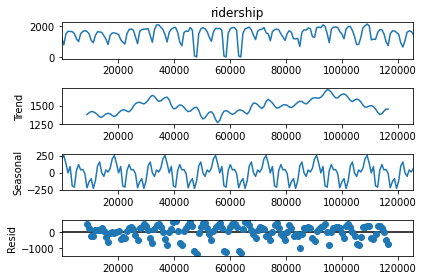

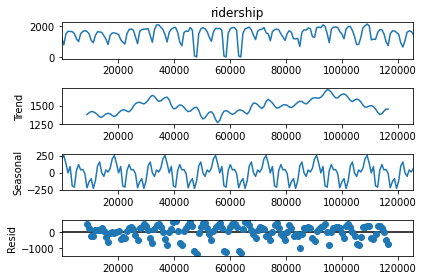

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data[data["stationID"]==2]["ridership"], 
                                   period=24)
decomposition.plot()

## Modelling

### Select 8 (c/a, station) combinations

In [59]:
def select_stations(data: pd.DataFrame, col: str):
  """select 8 stations with 2 in each of the 4 quartiles"""
  # get ridership of each quartile
  #### TODO: consider upper/lower fence too
  labels = ["q1", "q2", "q3", "q4"]
  data["quantile"] = pd.qcut(
      data[col], 
      q = 4, 
      labels = labels,
  )
  
  selected = pd.concat(
      [data[data["quantile"]==label].sample(2) for label in labels]
  )

  return selected

selected = select_stations(avg_rship_df, "avg_daily_rship")
selected_stIDs = selected.stationID.to_list()
selected

,c/a,station,stationID,avg_daily_rship,quantile
55,N418,BEDFORD-NOSTRAN,370,199.792262,q1
100,J035,111 ST,177,297.498016,q1
357,N045,81 ST-MUSEUM,213,755.061508,q2
275,R316,INTERVALE AV,630,589.067063,q2
423,H019,MORGAN AV,138,922.524206,q3
558,B004,7 AV,47,1387.799206,q3
667,R143,TIMES SQ-42 ST,502,2160.040079,q4
574,R602,BOROUGH HALL,708,1425.163889,q4


### Approach 1 - Lightgbm

#### Feature Engineering

In [73]:
class FeatureGenerator():

  """"""
  def __init__(self, n_lags, horizon):
    self.n_lags = n_lags# number of past values used to predict
    self.horizon = horizon# number of future values to be predicted
    stationID_chosen = "391"
    
  def time_delay_embedding(self, series: pd.Series):
    """
    for a given time series, returns features and labels
    series: time series as pd.Series
    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = "Series"
    else:
        name = series.name

    n_lags_iter = list(range(self.n_lags, -self.horizon, -1))

    df = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df, axis=1).dropna()
    df.columns = [f"{name}(t-{j - 1})"
                 if j > 0 else f"{name}(t+{np.abs(j) + 1})"
                 for j in n_lags_iter]

    return df

  def create_features_and_labels(self, data):
    """TODO"""
    
    df = self.time_delay_embedding(data["ridership"])
    # define X and Y
    predictor_var = df.columns.str.contains("\(t\-")
    target_var = df.columns.str.contains("\(t\+")
    X = df.iloc[:, predictor_var]
    # add time of day, day of week variables
    X["day_of_week"] = pd.to_datetime(X.index).day_of_week
    y = df.iloc[:, target_var]

    self.X = X
    self.y = y

    return self.X, self.y

def lgbm_train_and_forecast(X_tr, y_tr, X_ts, y_ts, ID: int):
  
  """TODO"""
  # create model
  lgbm_model = MultiOutputRegressor(LGBMRegressor())
  # fit model
  lgbm_model.fit(X_tr, y_tr)
  
  # getting forecasts for the test set
  forecast = lgbm_model.predict(X_ts)
  forecast_df = pd.DataFrame({
      "date": pd.date_range(start=y_ts.index[0], periods=14),
      "stationID": ID,
      "y_ts": y_ts.to_numpy()[0],
      "y_preds": forecast[0]
  })

  # Return the forecasted results
  return forecast_df

lgbm_data = data[data["stationID"].isin(selected_stIDs)][[
    "date", "stationID", "ridership"
]].set_index("date")
groups_by_ID = lgbm_data.groupby("stationID")

loop_forecast_lgbm = pd.DataFrame()
feature_generator = FeatureGenerator(n_lags=14, horizon=14)

# Loop through each ID
for ID in selected_stIDs:
  # Get the data for the ID
  group = groups_by_ID.get_group(ID)  
  X, y = feature_generator.create_features_and_labels(group)
  # train/test split
  X_tr, X_ts = X.iloc[:-1,:], X.iloc[-1:,:]
  y_tr, y_ts = y.iloc[:-1,:], y.iloc[-1:,:]
  # Make forecast
  forecast_df = lgbm_train_and_forecast(X_tr, y_tr, X_ts, y_ts, ID)
  # Add the forecast results to the dataframe
  loop_forecast_lgbm = pd.concat((loop_forecast_lgbm, forecast_df))

# have a look at the forecast
loop_forecast_lgbm


,date,stationID,y_ts,y_preds
0,2023-01-07,370,129.166667,154.703514
1,2023-01-08,370,110.166667,185.770658
2,2023-01-09,370,209.333333,170.689349
3,2023-01-10,370,227.333333,198.141351
4,2023-01-11,370,231.166667,234.189404
...,...,...,...,...
9,2023-01-16,708,749.166667,868.033890
10,2023-01-17,708,2007.000000,1814.093130
11,2023-01-18,708,2056.500000,2094.233589
12,2023-01-19,708,1889.333333,2139.647337


### Approach 2 - Prophet

In [74]:
# prepare dataset for prophet
train_test_cut_date = end_date - datetime.timedelta(days=14)
pro_data = data[data["stationID"].isin(selected_stIDs)][[
    "date", "stationID", "ridership"
]].rename(columns={
    "date": "ds",
    "ridership": "y"
})
pro_tr = pro_data[pro_data["ds"] < train_test_cut_date]
pro_ts = pro_data[pro_data["ds"] >= train_test_cut_date]
# Group the data by ID
groups_by_ID = pro_tr.groupby("stationID")

def prophet_train_and_forecast(group):
  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)
  # Make predictions
  future = m.make_future_dataframe(periods=14)
  forecast = m.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
  forecast["stationID"] = group["stationID"].iloc[0]
  # keep out of sample predictions only
  cut_date = forecast.ds.max().date()- datetime.timedelta(days=14)
  forecast = forecast[forecast["ds"].dt.date > cut_date]
  # Return the forecasted results
  return forecast[["ds", "stationID", "yhat", "yhat_upper", "yhat_lower"]]

# Create an empty dataframe
loop_forecast_prophet = pd.DataFrame()
# Loop through each ID
for ID in selected_stIDs:
  # Get the data for the ID
  group = groups_by_ID.get_group(ID)  
  # Make forecast
  forecast = prophet_train_and_forecast(group)
  # Add the forecast results to the dataframe
  loop_forecast_prophet = pd.concat((loop_forecast_prophet, forecast))
# Take a look at the forecast
loop_forecast_prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_ec_5nr/7dl7huwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_ec_5nr/8367fdqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85540', 'data', 'file=/tmp/tmpa_ec_5nr/7dl7huwy.json', 'init=/tmp/tmpa_ec_5nr/8367fdqc.json', 'output', 'file=/tmp/tmpa_ec_5nr/prophet_modellcsg9olb/prophet_model-20230126235431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:54:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

,ds,stationID,yhat,yhat_upper,yhat_lower
154,2023-01-07,370,128.531725,163.600089,90.702221
155,2023-01-08,370,110.463297,146.442286,73.325909
156,2023-01-09,370,169.987555,206.915065,135.295443
157,2023-01-10,370,192.803432,231.154146,156.263584
158,2023-01-11,370,200.709715,238.322585,165.098283
...,...,...,...,...,...
163,2023-01-16,708,1451.875553,1791.193681,1126.870735
164,2023-01-17,708,1720.884397,2056.851199,1380.839687
165,2023-01-18,708,1765.314125,2085.591723,1445.568983
166,2023-01-19,708,1725.936381,2084.833503,1376.727159


## Evaluation

In [62]:
# evaluate with mape and rmse
def evaluate_model(y, y_ts, y_preds):
  """prints evaluation metrics and makes evaluation plots"""

  print(f"MAPE: {mape(y_ts, y_preds)}")
  print(f"MAE: {round(mae(y_ts, y_preds), 4)}")
  print(f"RMSE: {round(mse(y_ts, y_preds, squared=False), 4)}")

  # plot actuals and predictions

# lightgbm
print("Lightgbm:")
evaluate_model(
    lgbm_data, loop_forecast_lgbm["y_ts"], loop_forecast_lgbm["y_preds"]
)

# prophet
print("Prophet:")
pro_ts["ds"] = pro_ts["ds"].astype("datetime64[ns]")
pro_eva = pro_ts.merge(
    loop_forecast_prophet, on=["ds", "stationID"], how="inner"
)
evaluate_model(
    pro_data, pro_eva["y"], pro_eva["yhat"]
)


Lightgbm:
MAPE: 3.2287507276428835
MAE: 144.7523
RMSE: 250.4107
Prophet:
MAPE: 2.3085794468944987
MAE: 142.1322
RMSE: 205.5497


In [87]:
loop_forecast_lgbm

,date,stationID,y_ts,y_preds
0,2023-01-07,370,129.166667,154.703514
1,2023-01-08,370,110.166667,185.770658
2,2023-01-09,370,209.333333,170.689349
3,2023-01-10,370,227.333333,198.141351
4,2023-01-11,370,231.166667,234.189404
...,...,...,...,...
9,2023-01-16,708,749.166667,868.033890
10,2023-01-17,708,2007.000000,1814.093130
11,2023-01-18,708,2056.500000,2094.233589
12,2023-01-19,708,1889.333333,2139.647337


In [63]:
pro_eva["diff"] = abs(pro_eva["y"] - pro_eva["yhat"])/pro_eva["y"]
print(pro_eva.sort_values("diff", ascending=False).to_string())

            ds  stationID            y         yhat   yhat_upper   yhat_lower        diff
65  2023-01-15        138     2.666667   593.474244   847.446326   349.853482  221.552842
57  2023-01-14        138    40.333333   746.109800  1011.103113   508.419065   17.498590
15  2023-01-08        708   207.000000   534.396159   868.345859   181.041332    1.581624
7   2023-01-07        708   302.500000   683.179853  1036.246597   320.805156    1.258446
79  2023-01-16        708   749.166667  1451.875553  1789.773813  1071.985102    0.937987
35  2023-01-11        213   548.000000   937.536250  1168.030415   714.112078    0.710833
83  2023-01-17        213   582.000000   959.206009  1183.973393   741.139370    0.648120
27  2023-01-10        213   603.500000   948.698788  1168.911937   708.187594    0.571995
91  2023-01-18        213   605.500000   948.043470  1169.317716   722.307133    0.565720
19  2023-01-09        213   545.166667   828.696525  1045.213332   604.065639    0.520079
75  2023-0

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=4)
i = 1
for ID in selected_stIDs:
  fig.add_trace(
      go.Scatter(x = lgbm_data.index,
                 y = lgbm_data["ridership"], 
                 name = "actual"),
      row=i, col=j
  )

fig.add_trace(
    go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

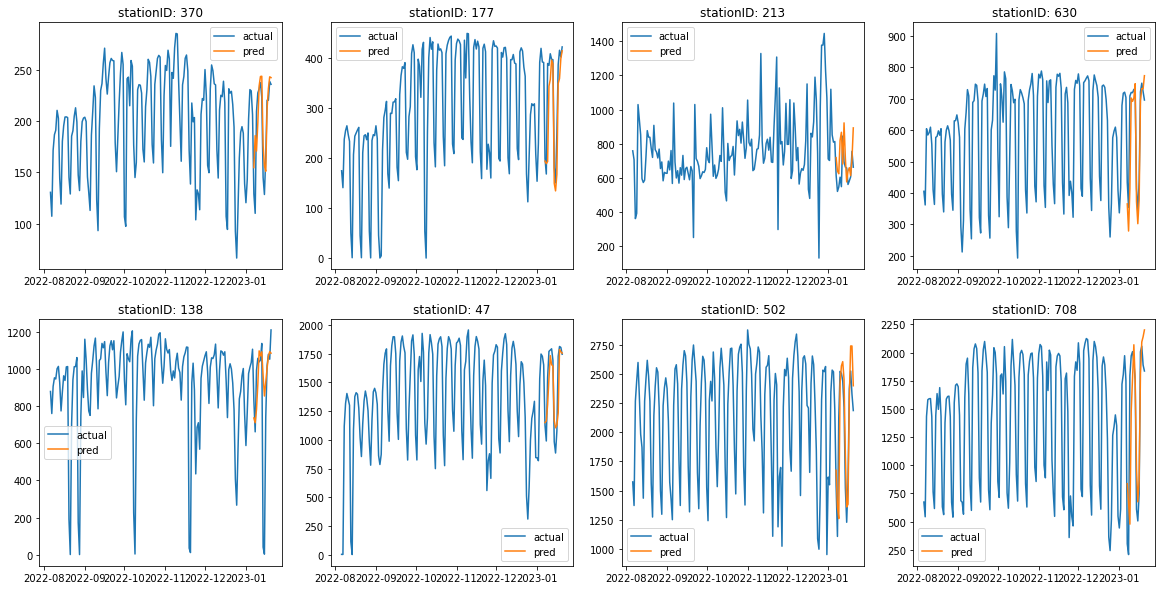

In [80]:
# Create a figure and axes for 8 plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

# Iterate over all unique station ids
for i, station_id in enumerate(selected_stIDs):
    # Filter data for each station id
    lgbm_data_station = lgbm_data[lgbm_data["stationID"] == station_id]
    loop_forecast_lgbm_station = loop_forecast_lgbm[
        loop_forecast_lgbm["stationID"] == station_id]
    # Plot the data on the current axes
    axes[i].plot(lgbm_data_station.index, 
                 lgbm_data_station["ridership"], 
                 label="actual")
    axes[i].plot(loop_forecast_lgbm_station["date"], 
                 loop_forecast_lgbm_station["y_preds"], 
                 label="pred")
    # Set the title of the current axes
    axes[i].set_title(f"stationID: {station_id}")
    # Add a legend
    axes[i].legend()

plt.show()

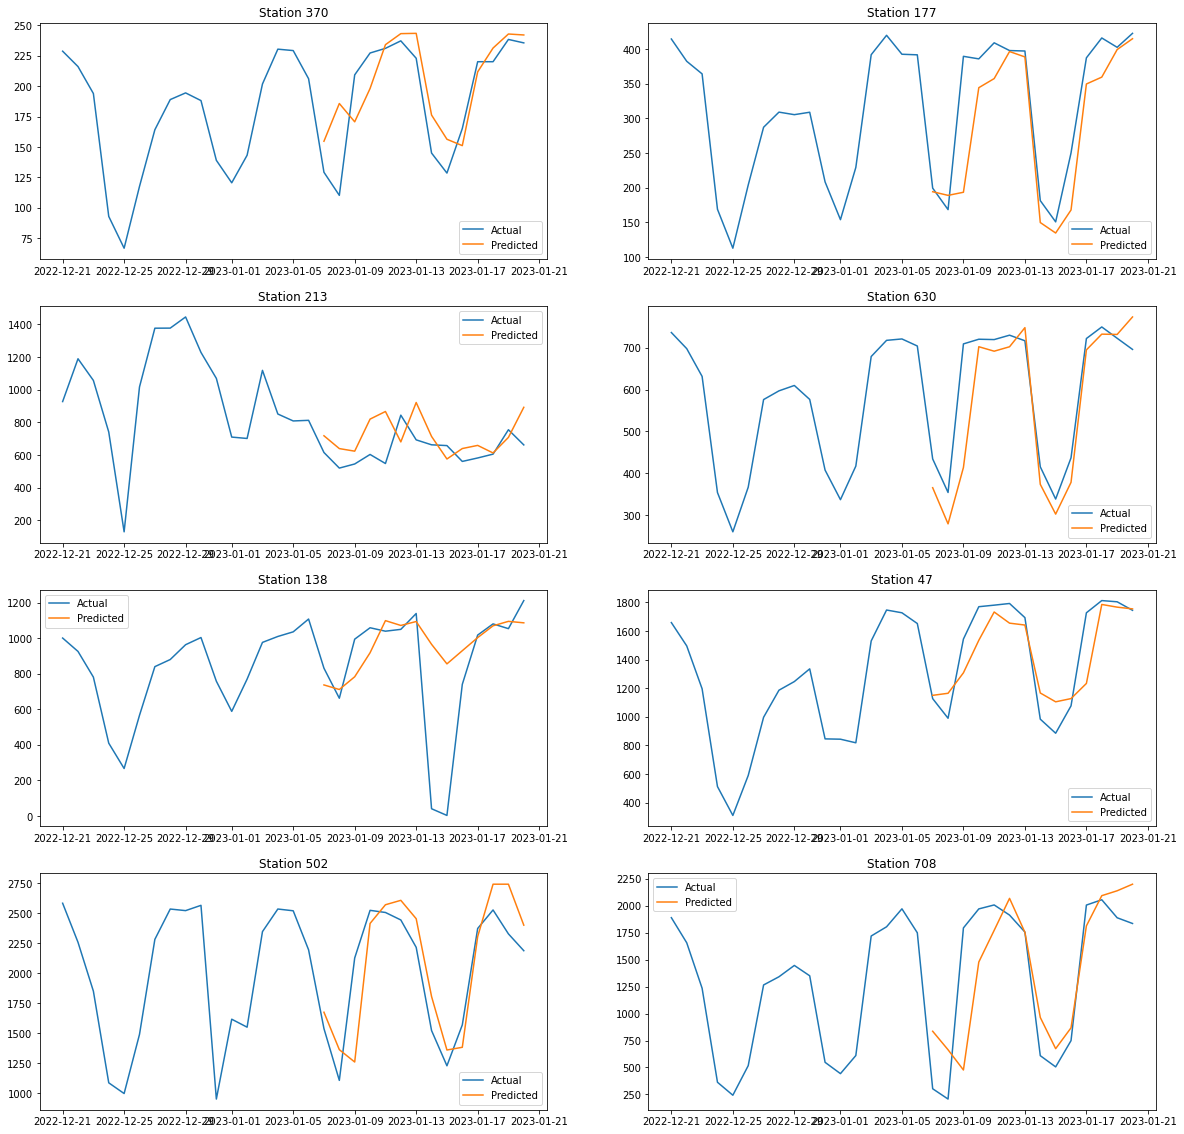

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter lgbm_data to only include the last 2 weeks
lgbm_data = lgbm_data[lgbm_data.index >= datetime.date(2022,12,21)]

# Create a figure with 8 subplots
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

# Loop through the stations and create a plot for each one
for i, station in enumerate(selected_stIDs):
    # Get the data for the current station
    data = lgbm_data[lgbm_data['stationID'] == station]
    forecast = loop_forecast_lgbm[loop_forecast_lgbm['stationID'] == station]

    # Get the subplot for the current station
    row = i // 2
    col = i % 2
    ax = axs[row][col]

    # Plot the ridership data
    ax.plot(data.index, data['ridership'], label='Actual')
    ax.plot(forecast['date'], forecast['y_preds'], label='Predicted')

    # Add a legend and set the title
    ax.legend()
    ax.set_title(f"Station {station}")

plt.show()

## Deployment

For the model deployment I would recommend doing these steps:

1. Creating an end-to-end pipeline (with for example sklearn library or mlflow)
2. Adding to the pipeline these steps:
  - downloading the data 
  - clean data
  - preprocess data
  - Feauture Engineering
  - train and forecast
  - evaluate model
3. If I am using cloud formation and serverless technology I would use perhaps another pipeline engine instead of sklearn. For example Vertex AI offers the possibility to use MLFlow  https://github.com/mlflow/mlflow and the alike for model deployment. I could work closely with the MLOPs team members to better elaborate on that.
4. Containerization 

## Improvements

### Modelling 

### Processing

### Coding